In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses
import matplotlib.pyplot as plt

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [ ]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "hugodarwood"
dataset_name = "epirecipes"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Download the dataset using Kaggle API
!kaggle datasets download -d $dataset_url

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

 44% 5.00M/11.3M [00:00<00:00, 37.1MB/s]
100% 11.3M/11.3M [00:00<00:00, 64.9MB/s]


the data can be loaded and filtered so that only recipes with a
title and a description remain

In [ ]:
# Load the full dataset
with open("/content/epirecipes/full_format_recipes.json") as json_data:
    recipe_data = json.load(json_data)

In [ ]:
# Filter the dataset
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

In [ ]:
# Count the recipes
n_recipes = len(filtered_data)
print(f"{n_recipes} recipes loaded")

20111 recipes loaded


In [ ]:
example = filtered_data[9]
print(example)

Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas  | Chop enough parsley leaves to measure 1 tablespoon; reserve. Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan, covered, 5 minutes. Meanwhile, sprinkle gelatin over water in a medium bowl and let soften 1 minute. Strain broth through a fine-mesh sieve into bowl with gelatin and stir to dissolve. Season with salt and pepper. Set bowl in an ice bath and cool to room temperature, stirring. Toss ham with reserved parsley and divide among jars. Pour gelatin on top and chill until set, at least 1 hour. Whisk together mayonnaise, mustard, vinegar, 1/4 teaspoon salt, and 1/4 teaspoon pepper in a large bowl. Stir in celery, cornichons, and potatoes. Pulse peas with marjoram, oil, 1/2 teaspoon pepper, and 1/4 teaspoon salt in a food processor to a coarse mash. Layer peas, then potato salad, over ham.


# Tokenization

**If you use word tokens:**

• All text can be converted to lowercase, to ensure capitalized words at the start of
sentences are tokenized the same way as the same words appearing in the middle
of a sentence. In some cases, however, this may not be desirable; for example,
some proper nouns, such as names or places, may benefit from remaining capi‐
talized so that they are tokenized independently.

• The text vocabulary (the set of distinct words in the training set) may be very
large, with some words appearing very sparsely or perhaps only once. It may be
wise to replace sparse words with a token for unknown word, rather than includ‐
ing them as separate tokens, to reduce the number of weights the neural network
needs to learn.

• Words can be stemmed, meaning that they are reduced to their simplest form, so
that different tenses of a verb remained tokenized together. For example, browse,
browsing, browses, and browsed would all be stemmed to brows.

• You will need to either tokenize the punctuation, or remove it altogether.

• Using word tokenization means that the model will never be able to predict
words outside of the training vocabulary.


**If you use character tokens:**

• The model may generate sequences of characters that form new words outside of
the training vocabulary—this may be desirable in some contexts, but not in
others.

• Capital letters can either be converted to their lowercase counterparts, or remain
as separate tokens.

• The vocabulary is usually much smaller when using character tokenization. This
is beneficial for model training speed as there are fewer weights to learn in the
final output layer.


For this example, we’ll use lowercase word tokenization, without word stemming.
We’ll also tokenize punctuation marks, as we would like the model to predict when it
should end sentences or use commas

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
# Display an example of a recipe
example_data = text_data[9]
example_data

'Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas | Chop enough parsley leaves to measure 1 tablespoon ; reserve . Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan , covered , 5 minutes . Meanwhile , sprinkle gelatin over water in a medium bowl and let soften 1 minute . Strain broth through a fine - mesh sieve into bowl with gelatin and stir to dissolve . Season with salt and pepper . Set bowl in an ice bath and cool to room temperature , stirring . Toss ham with reserved parsley and divide among jars . Pour gelatin on top and chill until set , at least 1 hour . Whisk together mayonnaise , mustard , vinegar , 1 / 4 teaspoon salt , and 1 / 4 teaspoon pepper in a large bowl . Stir in celery , cornichons , and potatoes . Pulse peas with marjoram , oil , 1 / 2 teaspoon pepper , and 1 / 4 teaspoon salt in a food processor to a coarse mash . Layer peas , then potato salad , over ham . '

Pad the punctuation marks, to treat them as separate words.

Convert to a TensorFlow Dataset.

Create a Keras TextVectorization layer to convert text to lowercase, give the
most prevalent 10,000 words a corresponding integer token, and trim or pad the
sequence to 201 tokens long.

Apply the TextVectorization layer to the training data.

The vocab variable stores a list of the word tokens.

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

 we can see a subset of the list of tokens mapped to their respective
indices. The layer reserves the 0 token for padding (i.e., it is the stop token) and the 1
token for unknown words that fall outside the top 10,000 words (e.g., persillade). The
other words are assigned tokens in order of frequency. The number of words to
include in the vocabulary is also a parameter of the training process. The more words
included, the fewer unknown tokens you will see in the text; however, your model will
need to be larger to accommodate the larger vocabulary size.


In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: .
3: ,
4: and
5: to
6: in
7: the
8: with
9: a


The sequence
length that we use to train the model is a parameter of the training process. In this
example we choose to use a sequence length of 200, so we pad or clip the recipe to
one more than this length, to allow us to create the target variable

In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[  26   16  557    1    8  298  335  189    4 1054  494   27  332  228
  235  262    5  594   11  133   22  311    2  332   45  262    4  671
    4   70    8  171    4   81    6    9   65   80    3  121    3   59
   12    2  299    3   88  650   20   39    6    9   29   21    4   67
  529   11  164    2  320  171  102    9  374   13  643  306   25   21
    8  650    4   42    5  931    2   63    8   24    4   33    2  114
   21    6  178  181 1245    4   60    5  140  112    3   48    2  117
  557    8  285  235    4  200  292  980    2  107  650   28   72    4
  108   10  114    3   57  204   11  172    2   73  110  482    3  298
    3  190    3   11   23   32  142   24    3    4   11   23   32  142
   33    6    9   30   21    2   42    6  353    3 3224    3    4  150
    2  437  494    8 1281    3   37    3   11   23   15  142   33    3
    4   11   23   32  142   24    6    9  291  188    5    9  412  572
    2  230  494    3   46  335  189    3   20  557    2    0    0    0
    0 

# Create the Training Set

Our LSTM will be trained to predict the next word in a sequence, given a sequence of
words preceding this point.

For example, we could feed the model the tokens for grilled chicken with boiled and would expect the model to output a suitable next word
(e.g., potatoes, rather than bananas).


We can therefore simply shift the entire sequence by one token in order to create our
target variable.


In [ ]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

# Build the LSTM

The input to the
model is a sequence of integer tokens and the output is the probability of each word
in the 10,000-word vocabulary appearing next in the sequence

An embedding layer is essentially a lookup table that converts each integer token into
a vector of length embedding_size. The lookup vectors are
learned by the model as weights. Therefore, the number of weights learned by this
layer is equal to the size of the vocabulary multiplied by the dimension of the embed‐
ding vector (i.e., 10,000 × 100 = 1,000,000).

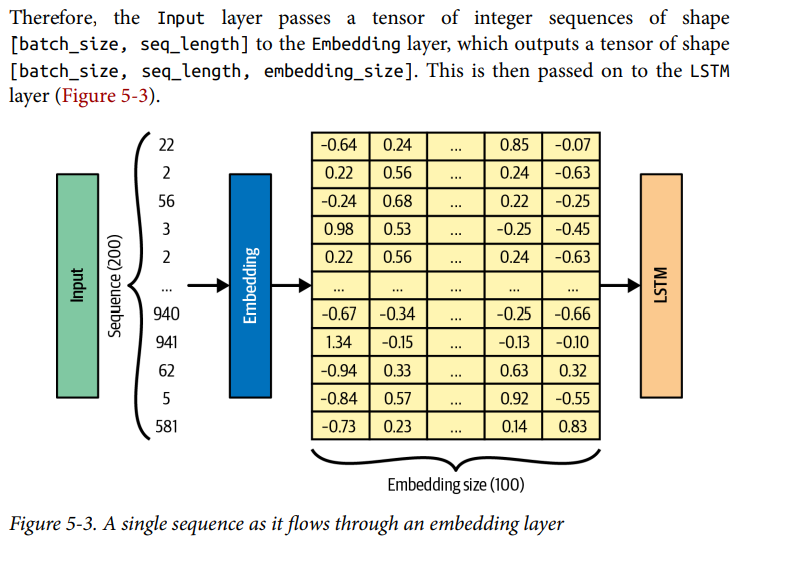

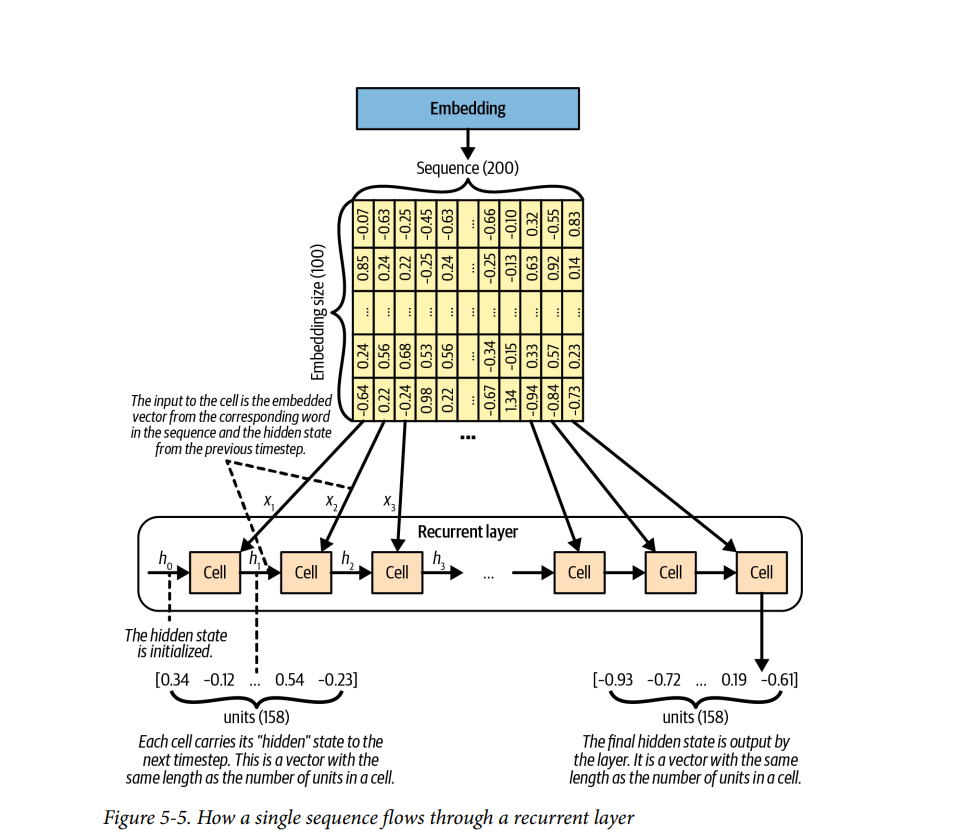

In [ ]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 dense (Dense)               (None, None, 10000)       1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 2407248 (9.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }  # <1>

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]  # <3>
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:  # <4>
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)  # <5>
            sample_token, probs = self.sample_from(y[0][-1], temperature)  # <6>
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # <7>
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, text_generator],
)

Epoch 1/25
628/629 [============================>.] - ETA: 0s - loss: 4.3878
generated text:
recipe for wendy mayonnaise in medium the layer . cook from dough , zest shouldn juice to baking saucepan through . pepper . and back down rack . whisk 12 minutes and until bouillon together rub for zucchini and further and plain bring and trim side . side ; immediately and hoisin in cilantro , layer with bowl ( sautéed tablespoons cream , and simmer , warm - caramel into cut week mixture enough turkey ahead of chopped can well ahead longer until golden to ice onion minutes are smooth 

629/629 [==============================] - 60s 90ms/step - loss: 4.3860
Epoch 2/25
628/629 [============================>.] - ETA: 0s - loss: 2.9778
generated text:
recipe for flemish shortcakes with crouton and herb sauce | scallions steaks with salt , then in small bowl with vegetable cookie bean and shake occasionally . simmer until tender , about 4 minutes with 15 longer . place 2 bones on center of pork . b

Now that we have compiled and trained the LSTM, we can start to use it to generate
long strings of text by applying the following process:

1. Feed the network with an existing sequence of words and ask it to predict the fol‐
lowing word.

2. Append this word to the existing sequence and repeat.


The network will output a set of probabilities for each word that we can sample from.
Therefore, we can make the text generation stochastic, rather than deterministic.
Moreover, we can introduce a temperature parameter to the sampling process to indi‐
cate how deterministic we would like the process to be.

A temperature close to 0 makes the sampling more deterministic
(i.e., the word with the highest probability is very likely to be
chosen), whereas a temperature of 1 means each word is chosen
with the probability output by the model.

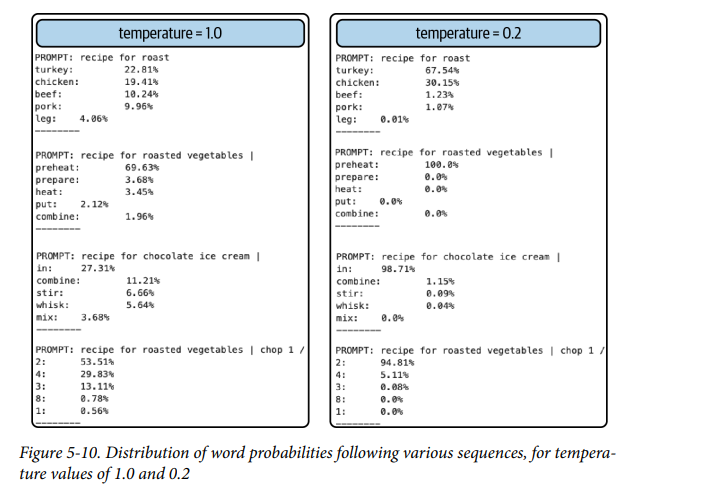

The model is able to generate a suitable distribution for the next most likely word
across a range of contexts. For example, even though the model was never told about
parts of speech such as nouns, verbs, or numbers, it is generally able to separate
words into these classes and use them in a way that is grammatically correct.

Moreover, the model is able to select an appropriate verb to begin the recipe instructions, depending on the preceding title. For roasted vegetables, it selects preheat,
prepare, heat, put, or combine as the most likely possibilities, whereas for ice cream
it selects in, combine, stir, whisk, and mix. This shows that the model has some contextual understanding of the differences between recipes depending on their
ingredients.


Notice also how the probabilities for the temperature = 0.2 examples are much
more heavily weighted toward the first choice token. This is the reason why there is
generally less variety in generations when the temperature is lower.

In [ ]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=1.0
)


generated text:
recipe for roasted vegetables | chop 1 / 4 cup



In [ ]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	38.68%
4:   	38.68%
3:   	14.7%
8:   	2.33%
off:   	0.92%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 4
cup:   	60.19%
of:   	17.12%
teaspoon:   	4.24%
garlic:   	2.27%
tablespoon:   	1.52%
--------



In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=0.2
)


generated text:
recipe for roasted vegetables | chop 1 / 2 cup



In [ ]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	49.82%
4:   	49.79%
3:   	0.39%
8:   	0.0%
off:   	0.0%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 2
cup:   	99.83%
teaspoon:   	0.13%
tablespoon:   	0.04%
of:   	0.0%
garlic:   	0.0%
--------



In [ ]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=1.0
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | bring


PROMPT: recipe for chocolate ice cream |
combine:   	12.9%
in:   	7.45%
1:   	7.14%
whisk:   	6.73%
preheat:   	5.48%
--------



In [ ]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=0.2
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | in


PROMPT: recipe for chocolate ice cream |
combine:   	84.35%
in:   	5.41%
1:   	4.38%
whisk:   	3.26%
preheat:   	1.17%
--------



# Stacked Recurrent Units

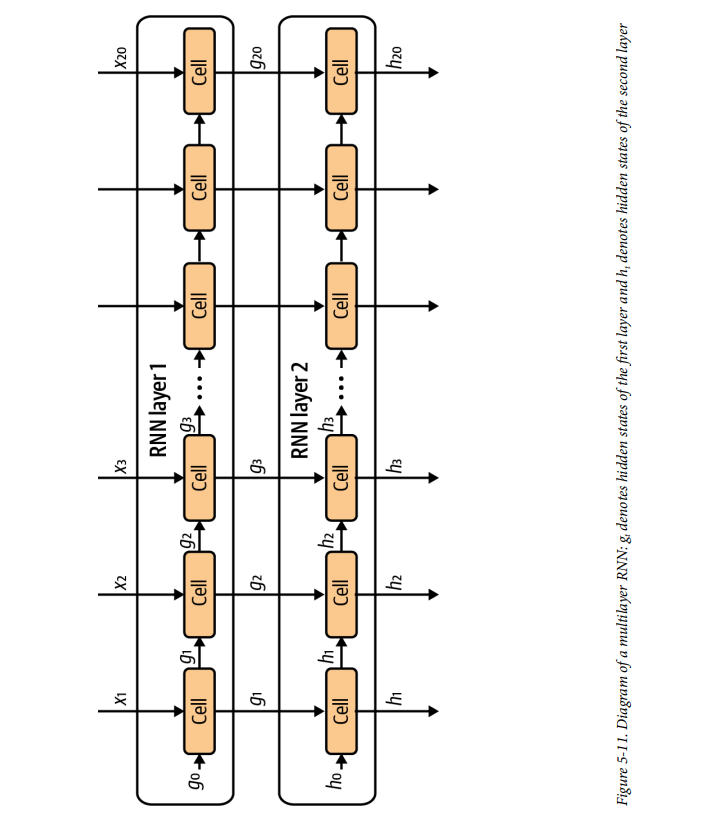

In [ ]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         131584    
                                                                 
 dense_1 (Dense)             (None, None, 10000)       1290000   
                                                                 
Total params: 2538832 (9.68 MB)
Trainable params: 2538832 (9.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

In [ ]:
lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, text_generator],
)

Epoch 1/25
629/629 [==============================] - ETA: 0s - loss: 4.6215
generated text:
recipe for whisk leek orange pot fish adding | 15 preheat water and and drain occasionally pinch . in finely . over 1 simmer season salt for . , . high 40 over cups in strawberry 1 vinegar stir masa reserve 1 oil add saucepan cook into celery over onion fennel ready until ; a this minutes to squeezing until golden is lentils draw . sprinkle add ahead pat . plastic cover and to ; on , a spices is . ; salt to rewhisk each place leaves . . between , tomatoes in frozen grind in hours pastry center

629/629 [==============================] - 55s 82ms/step - loss: 4.6215
Epoch 2/25
629/629 [==============================] - ETA: 0s - loss: 3.5811
generated text:
recipe for baked coconut and mascarpone & salsa | place the bell ingredients and mash paper the gum , any 3 / bottomed cup , just legs in medium water . mix sauce is small - sieve . rub mustard , onion over small pot in a saucepan and whisk t